In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
#device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [3]:
#preproccessing images
def read_images(path, num_images):
    array = np.zeros([num_images, 64*32])
    i = 0
    for image in os.listdir(path):
        img_path =  path +  "\\" + image
        image =  Image.open(img_path, mode= "r")
        data = np.asarray(image, dtype= "uint8")
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

#read negative
train_neg_path = r"C:\Users\yagiz\Desktop\data\LSIFIR\Classification\Train\neg"
num_train_neg_images = 43390

train_neg_array = read_images(train_neg_path, num_train_neg_images)

In [4]:
#negative tensors
x_train_neg_tensor = torch.from_numpy(train_neg_array)
print("x_train_neg_tensor: ", x_train_neg_tensor.size())

y_train_neg_tensor = torch.zeros(num_train_neg_images, dtype=torch.long)
print(y_train_neg_tensor.size())


x_train_neg_tensor:  torch.Size([43390, 2048])
torch.Size([43390])


In [5]:
#read positives
train_pos_path = r"C:\Users\yagiz\Desktop\data\LSIFIR\Classification\Train\pos"
num_train_pos_images = 10208
train_pos_array = read_images(train_pos_path, num_train_pos_images)


In [8]:
x_train_pos_tensor = torch.from_numpy(train_pos_array)
print("x_train_pos_tensor: ", x_train_pos_tensor.size())

y_train_pos_tensor = torch.ones(num_train_pos_images, dtype=torch.long)
print("y_train_pos_tensor: ", y_train_pos_tensor.size())

x_train_pos_tensor:  torch.Size([10208, 2048])
y_train_pos_tensor:  torch.Size([10208])


In [10]:
#concat train
x_train = torch.cat((x_train_neg_tensor, x_train_pos_tensor), 0)
y_train = torch.cat((y_train_neg_tensor, y_train_pos_tensor), 0)
print("x train: ", x_train.size())
print("y train: ", y_train.size())

x train:  torch.Size([53598, 2048])
y train:  torch.Size([53598])


In [13]:
#test images
#reading test negatives
test_neg_path = r"C:\Users\yagiz\Desktop\data\LSIFIR\Classification\Test\neg"
num_test_neg_images = 22050
test_negative_array = read_images(test_neg_path, num_test_neg_images)
x_test_neg_tensor = torch.from_numpy(test_negative_array[:20855,:])
print("x_test_negative_tensor: ", x_test_neg_tensor.size())
y_test_neg_tensor = torch.ones(20855, dtype= torch.long)
print("y_test_neg_tensor: ", y_test_neg_tensor.size())

#reading test positives
test_pos_path = r"C:\Users\yagiz\Desktop\data\LSIFIR\Classification\Test\pos"
num_test_pos_images = 5944
test_pos_array = read_images(test_pos_path, num_test_pos_images)
x_test_pos_tensor = torch.from_numpy(test_pos_array)
print("x_test_pos_tensor: ", x_test_pos_tensor.size())
y_test_pos_tensor = torch.ones(num_test_pos_images, dtype=torch.long)
print("y_test_pos_tensor: ", y_test_pos_tensor.size())

#concat test
x_test = torch.cat((x_test_neg_tensor, x_test_pos_tensor), 0)
y_test = torch.cat((y_test_neg_tensor, y_test_pos_tensor), 0)
print("x_test: ", x_test.size())
print("y_test: ", y_test.size())

x_test_negative_tensor:  torch.Size([20855, 2048])
y_test_neg_tensor:  torch.Size([20855])
x_test_pos_tensor:  torch.Size([5944, 2048])
y_test_pos_tensor:  torch.Size([5944])
x_test:  torch.Size([26799, 2048])
y_test:  torch.Size([26799])


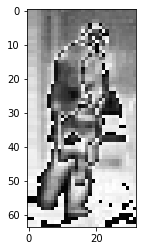

In [14]:
#visualizing
plt.imshow(x_train[45001,:].reshape(64, 32), cmap="gray")

In [31]:
#CNN IMPLEMENTING

# -> Hyper Parameters
num_epochs = 5000
num_classes = 2
batch_size = 6
batch_size_t = 2
learning_rate = 0.00001

class Net(nn.Module):
    
    def __init__(self) -> None:
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)

        self.fc1 = nn.Linear(16*13*5, 520) ## image is downscaled to 13 x 5 from 64 x 32. And we have 16 feature maps (last conv2d)
        self.fc2 = nn.Linear(520, 130)
        self.fc3 = nn.Linear(130, num_classes)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16*5*13)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
        

In [32]:
#matching labels and data >>>>>>>>
train = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size_t, shuffle = False)

In [26]:
#calling net
net = Net().to(device=device)

#loss and optimizer
criteria = nn.CrossEntropyLoss()

import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.8)


In [37]:
#training the neural network

start_time = time.time()

train_accuracy = []
test_accuracy = []
loss_list = []

use_gpu = True

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs = inputs.view(batch_size, 1, 64, 32) #reshaping
        inputs = inputs.float()

        if use_gpu:
            if torch.cuda.is_available():
                inputs, labels  = inputs.to(device), labels.to(device)

        optimizer.zero_grad() ## zero gradient --gradients are being summed, we want them to be zero for every epoch
        outputs = net(inputs) ## forward prediction
        loss = criteria(outputs, labels) ## calculating loss
        #back propogation >>> loss.backward
        loss.backward()
        optimizer.step() ## update weights

    #test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data

            images = images.view(images.size(0), 1, 64, 32)
            images = images.float()

            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            output = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #correct += (predicted == labels).sum().item()
    
    acc1 = (correct/total) * 100
    print("Accuracy test: ", acc1)
    test_accuracy.append(acc1)
       
    #train test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data

            images = images.view(images.size(0), 1, 64, 32)
            images = images.float()

            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            output = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #correct += (predicted == labels).sum().item()
    
    acc2 = (correct/total) * 100
    print("Accuracy train: ", acc2)
    train_accuracy.append(acc2)

print("Train is done.")

end_time = time.time()
process_time = end_time - start_time / 60
print("Process Time: ", process_time)

Accuracy test:  0.0
Accuracy train:  0.0
Accuracy test:  0.0
Accuracy train:  0.0


KeyboardInterrupt: 